In [1]:
import json
import os
import shutil
import time
from base64 import b64decode
from io import BytesIO
from IPython import get_ipython
from IPython.core.magic import register_cell_magic
from skimage import data

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import PIL
import seaborn as sns
#%config InlineBackend.figure_format = 'svg'  

@register_cell_magic
def capture_png(line, cell):
    get_ipython().run_cell_magic(
        'capture',
        ' --no-stderr --no-stdout result',
        cell
    )


    out_paths = line.strip().split(' ')
    for output in result.outputs:
        display(output)
        
        data = output.data
        if 'image/png' in data:
            path = out_paths.pop(0)
            path = path.split(".png")[0] + str(time.time_ns()) + ".png"
            if not path:
                raise ValueError('Too few paths given!')
            png_bytes = data['image/png']
            if isinstance(png_bytes, str):
                png_bytes = b64decode(png_bytes)
            assert isinstance(png_bytes, bytes)
            bytes_io = BytesIO(png_bytes)
            image = PIL.Image.open(bytes_io)
            image.save(path, 'png')
            
        code =cell

        with open("imgs/3d_morphology.json", "r") as jsonFile:
            data = json.load(jsonFile)

        data[path[5:]] = code

        with open("imgs/3d_morphology.json", "w") as jsonFile:
            json.dump(data, jsonFile, indent=2)

        
temp_path = Path.cwd() / "temp_images"
temp_path.mkdir(parents=False, exist_ok=True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from skimage.morphology import ball, cube, octahedron






def structuring_element(array, structure, position=None, alignment_to_index="center"):
    """Draw a structuring element.

    Parameters
    ----------
    array: ndarray
        An array where the structuring element will be placed.
    structure: ndarray
        A structuring element.
    position: array_like, optional
        The position of the structuring element in the output image.
        When no position is given, the stucuting element will be drawn in the center of the array.
        If one or more array axis haven an even count of total elements and therefore no integer as center index,
        the center index is rounded down to the next integer.
    alignment_to_index: string, optional
        Can be either "center" or "corner".
    """
    if position == None:
        i, j, k = array.shape
        position = np.array(
            [int(np.ceil(i / 2)), int(np.ceil(j / 2)), int(np.ceil(k / 2))]
        )
    x = position[0]
    y = position[1]
    z = position[2]
    strulen_x = structure.shape[0]
    strulen_y = structure.shape[1]
    strulen_z = structure.shape[2]
    if alignment_to_index == "center":
        halfxA = int(np.floor(strulen_x / 2))
        halfxB = int(np.ceil(strulen_x / 2))
        halfyA = int(np.floor(strulen_y / 2))
        halfyB = int(np.ceil(strulen_y / 2))
        halfzA = int(np.floor(strulen_z / 2))
        halfzB = int(np.ceil(strulen_z / 2))
        array[
            x - halfxA : x + halfxB, y - halfyA : y + halfyB, z - halfzA : z + halfzB
        ] = structure
    if alignment_to_index == "corner":
        array[x : x + strulen_x, y : y + strulen_y, z : z + strulen_z] = structure

    return array



def plot_voxels(varray, ax= None, title= None, linewidth=0.8):
    cmap = plt.get_cmap("YlGnBu")

    if ax == None:
        fig = plt.figure(figsize=(16/2, 9/2))
        ax = fig.add_subplot(1, 1,1, projection="3d")
    ax.view_init(20, 200)
    colors = cmap(varray)
    ax.voxels(varray, facecolors=colors, edgecolor="black", linewidth=linewidth)

    #ax.axis('off')
    if title != None:
        ax.set_title(title, fontsize=30)

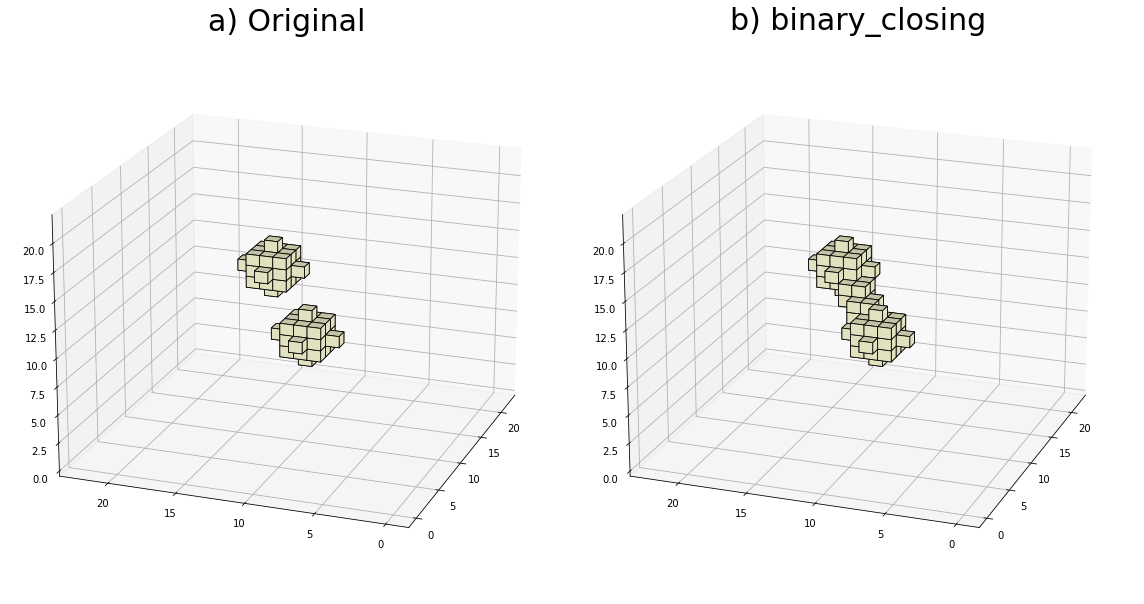

In [3]:
%%capture_png imgs/example.png
import matplotlib.pyplot as plt
import numpy as np
import scipy
from skimage.morphology import ball

voxelarray = np.full((22, 22, 22), 0)
voxelarray = structuring_element(voxelarray, ball(2), position=(9, 9, 9))
voxelarray = structuring_element(voxelarray, ball(2), position=(13, 13, 13))

voxelarray2 = scipy.ndimage.binary_closing(voxelarray, ball(5))

fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
plot_voxels(voxelarray, ax1, title="a) Original")
plot_voxels(voxelarray2, ax2, title="b) binary_closing")
plt.tight_layout()
plt.show()

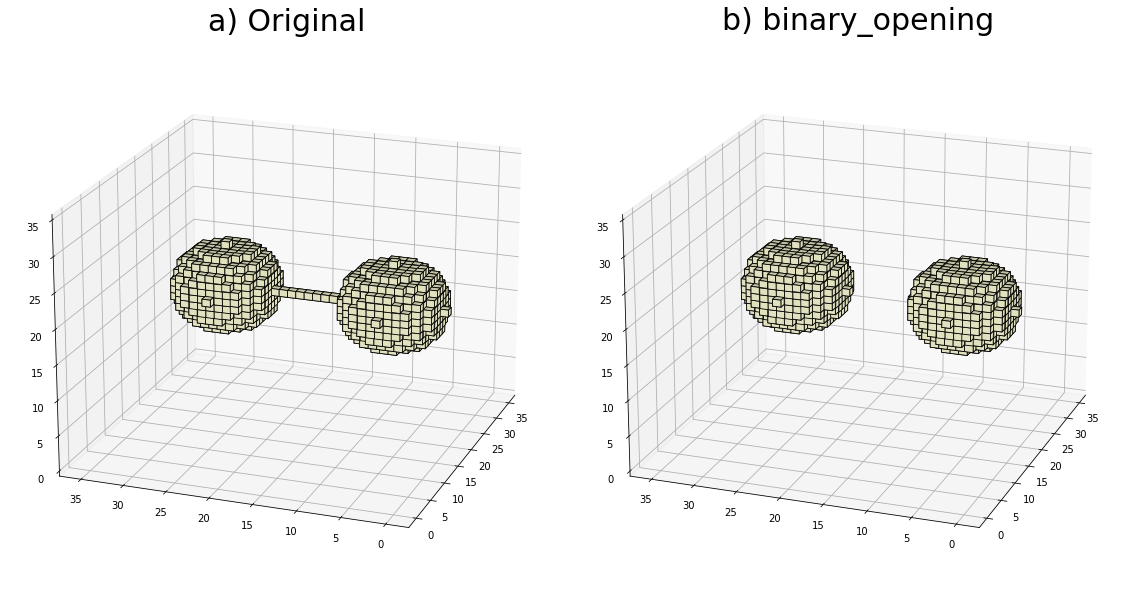

In [4]:
%%capture_png imgs/example.png
import matplotlib.pyplot as plt
import numpy as np
import scipy
from skimage.morphology import ball

voxelarray = np.full((35, 35, 35), 0)
voxelarray = structuring_element(voxelarray, ball(6), position=(22, 7, 17))
voxelarray = structuring_element(voxelarray, ball(6), position=(22, 27, 17))
voxelarray[22, 7:27, 17] = 1

voxelarray2 = scipy.ndimage.binary_opening(voxelarray, ball(2))

fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
plot_voxels(voxelarray, ax1, title="a) Original")
plot_voxels(voxelarray2, ax2, title="b) binary_opening")
plt.tight_layout()
plt.show()

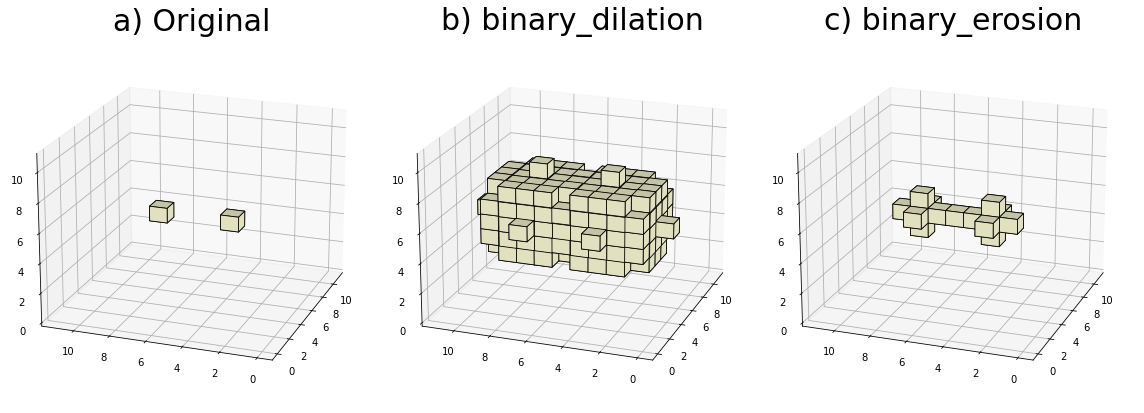

In [5]:
%%capture_png imgs/example.png
voxelarray = np.full((11, 11, 11), 0)
voxelarray[5, 3, 5] = 1
voxelarray[5, 7, 5] = 1


img_morphed = scipy.ndimage.binary_dilation(voxelarray, ball(3))
img_morphed2 = scipy.ndimage.binary_erosion(img_morphed, ball(2))


fig = plt.figure(figsize=(16, 9))
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
plot_voxels(voxelarray, ax1, title="a) Original")
plot_voxels(img_morphed, ax2, title="b) binary_dilation")
plot_voxels(img_morphed2, ax3, title="c) binary_erosion")
plt.tight_layout()
plt.show()

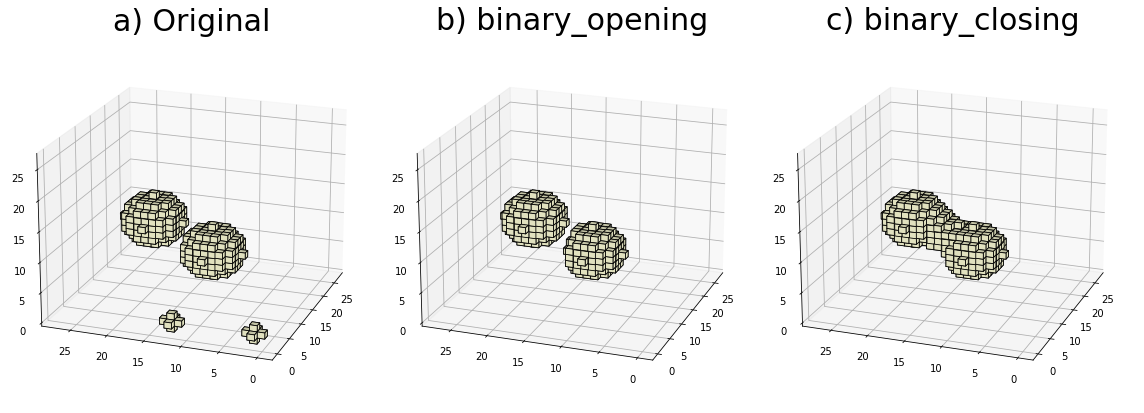

In [6]:
%%capture_png imgs/example.png
voxelarray = np.full((27, 27, 27), 0)
voxelarray = structuring_element(voxelarray, ball(1), position=(1, 1, 1))
voxelarray = structuring_element(voxelarray, ball(1), position=(1, 12, 1))
voxelarray = structuring_element(voxelarray, ball(4), position=(8, 9, 10))
voxelarray = structuring_element(voxelarray, ball(4), position=(8, 17, 14))

img_morphed = scipy.ndimage.binary_opening(voxelarray, ball(3))
img_morphed2 = scipy.ndimage.binary_closing(img_morphed, ball(4))

fig = plt.figure(figsize=(16 , 9 ))
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax3 = fig.add_subplot(1, 3, 3, projection="3d")

plot_voxels(voxelarray, ax1, title="a) Original")
plot_voxels(img_morphed, ax2, title="b) binary_opening")
plot_voxels(img_morphed2, ax3, title="c) binary_closing")
plt.tight_layout()
